In [0]:
# mount google drive to access the image dataset

from google.colab import drive
drive.mount('/content/drive')

In [0]:
import cv2
import numpy as np
import pandas as pd
import re
import math
from skimage import feature
from skimage.feature import hog
from imutils import paths
from google.colab.patches import cv2_imshow
import os

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Load Inception_v3 pretrained on ImageNet dataset
#model = InceptionV3(include_top=False, weights='imagenet', pooling='avg', input_tensor=Input(shape=(299,299,3)))
model = Xception(include_top=False, weights='imagenet', pooling='avg')

# List of paths 
file_list=[]
file_list.append(os.listdir(r"/content/drive/My Drive/Base/humanos"))
file_list.append(os.listdir(r"/content/drive/My Drive/Base/praia"))
file_list.append(os.listdir(r"/content/drive/My Drive/Base/obras"))
file_list.append(os.listdir(r"/content/drive/My Drive/Base/onibus"))
file_list.append(os.listdir(r"/content/drive/My Drive/Base/dino"))
file_list.append(os.listdir(r"/content/drive/My Drive/Base/elefante"))
file_list.append(os.listdir(r"/content/drive/My Drive/Base/flores"))
file_list.append(os.listdir(r"/content/drive/My Drive/Base/cavalos"))
file_list.append(os.listdir(r"/content/drive/My Drive/Base/montanhas"))
file_list.append(os.listdir(r"/content/drive/My Drive/Base/comida"))

# general path
path='/content/drive/My Drive/Base/'

# list of classes
class_names=['humanos', 'praia', 'obras', 'onibus', 'dino', 'elefante', 'flores', 'cavalos', 'montanhas', 'comida'] 

X = []
X_deep = []
y = []

# Feature extraction
for classes_files, classe in zip (file_list, range(10)):
    for i in range(100):
      name= str(path) + str(class_names[classe]) + str('/') + str(classes_files[i]) 
      imagem = cv2.imread(name)
      print(imagem.shape)
      altura, largura, _ = imagem.shape
    
# Convert the image to RGB and Gray    
      cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
      rgb   = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

# Color Histograms
      r_histograma = cv2.calcHist([rgb], [0], None, [256], [0, 256])/(altura*largura)
      g_histograma = cv2.calcHist([rgb], [1], None, [256], [0, 256])/(altura*largura)
      b_histograma = cv2.calcHist([rgb], [2], None, [256], [0, 256])/(altura*largura)

# Local Binary Pattern (LBP)
      lbp = feature.local_binary_pattern(cinza, 59, 1, method="uniform")
      (lbp_histograma, _) = np.histogram(lbp.ravel(), bins=59, range=(0, 59))
      lbp_histograma = lbp_histograma.astype("float")
      lbp_histograma /= (lbp_histograma.sum())
    
# Hog (Hostogram of Gradient - Direction)
      hg = hog(cinza, orientations=8, pixels_per_cell=(32, 32), cells_per_block=(8, 8), block_norm='L2-Hys')
    
# Concatenate the handcrafted feature sets
      X_image = [lbp_histograma, hg, r_histograma, g_histograma, b_histograma]    
      X_image_aux = []
      for aux in X_image:
          X_image_aux = np.append(X_image_aux, np.ravel(aux))
    
      X_image = [i for i in X_image_aux]
      y.append(classe)
      X.append(X_image)
      
# Extract deep features using InceptionV3 pretrained model 
      img = cv2.resize(imagem,(299,299))
      xd = image.img_to_array(img)
      xd = np.expand_dims(xd, axis=0)
      xd = preprocess_input(xd)
      deep_features = model.predict(xd)
      print(deep_features.shape)
      
      X_image_aux = []
      for aux in deep_features:
          X_image_aux = np.append(X_image_aux, np.ravel(aux))
    
      deep_features = [i for i in X_image_aux]
      
      X_deep.append(deep_features)

            
# Saving the extracted features (handcrafted) in a csv file
df = pd.DataFrame(X)
df.to_csv('X.csv', header=False, index=False)

# Saving the extracted features (deep) in a csv file
df = pd.DataFrame(X_deep)
df.to_csv('X_deep.csv', header=False, index=False)

# Saving the classes in a csv file
df_class = pd.DataFrame(y)
df_class.to_csv('y.csv', header=False, index=False)

In [0]:
# Example: how to load the csv files (features and labels)

import pandas as pd
import numpy as np

# Labels
y = pd.read_csv('/content/drive/My Drive/y.csv', header=None)
y=y.to_numpy()
y=np.ravel(y)
print(y.shape)

# handcrafted features
#X = pd.read_csv('X.csv', header=None)
#X=X.to_numpy()
#print(X.shape)

# deep features
X = pd.read_csv('/content/drive/My Drive/X_deep.csv', header=None)
X = X.to_numpy()
print(X.shape)

========================Naive Bayes=============================
Result for X
Accuracy = 0.86 
Confusion Matrix:
[[26  0  2  0  0  0  0  0  1  1]
 [ 1 20  1  1  0  0  0  1  6  0]
 [ 3  4 22  0  0  1  0  0  0  0]
 [ 0  0  0 29  0  0  0  0  0  1]
 [ 0  0  0  0 28  0  0  0  0  2]
 [ 1  1  1  0  0 27  0  0  0  0]
 [ 0  0  0  0  0  0 27  0  0  3]
 [ 0  0  4  0  0  0  0 26  0  0]
 [ 1  2  2  0  0  0  0  0 24  1]
 [ 0  0  0  0  0  0  1  0  1 28]]

Cross Validation Results 10 folds:
Mean Accuracy: 0.82
Mean Std: 0.03
Confusion Matrix:
[[80  0  5  1  0  5  0  2  3  4]
 [ 3 76  3  2  0  1  0  1 12  2]
 [15  8 62  1  0  7  1  1  1  4]
 [ 0  0  0 96  0  0  0  0  1  3]
 [ 0  0  0  0 98  2  0  0  0  0]
 [ 5  4  1  0  0 87  0  2  1  0]
 [ 2  2  0  0  0  0 91  0  1  4]
 [ 2  0  8  2  0  3  0 84  1  0]
 [ 5 13  4  0  0  0  2  0 72  4]
 [10  0  1  0  0  3  1  0  6 79]]
Result for X_deep
Accuracy = 0.91 
Confusion Matrix:
[[29  1  0  0  0  0  0  0  0  0]
 [ 4 25  1  0  0  0  0  0  0  0]
 [ 3  0 27  0  0 

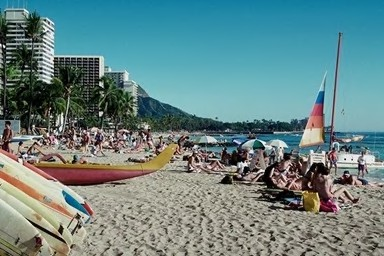

Label: 2 obras   /  Prediction:  0 humanos 1.0
/content/drive/My Drive/Base/obras/277.jpg


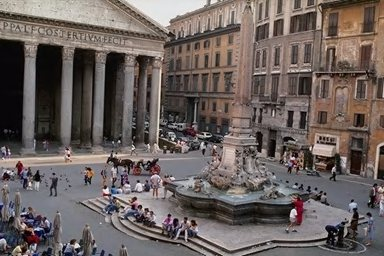

Label: 6 flores   /  Prediction:  9 comida 1.0
/content/drive/My Drive/Base/flores/661.jpg


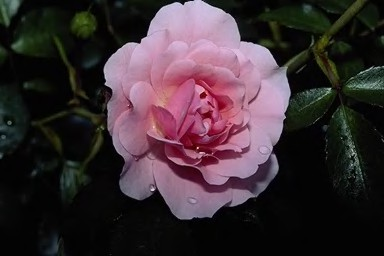

Label: 5 elefante   /  Prediction:  0 humanos 1.0
/content/drive/My Drive/Base/elefante/526.jpg


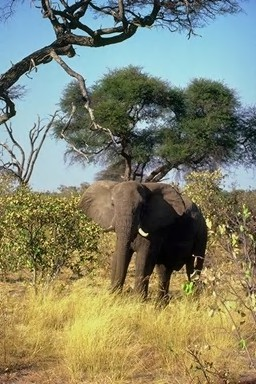

Label: 6 flores   /  Prediction:  0 humanos 1.0
/content/drive/My Drive/Base/flores/603.jpg


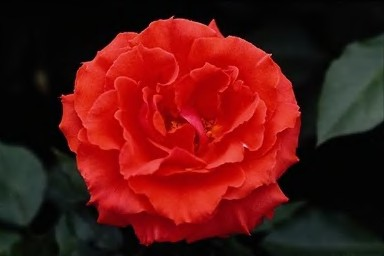

Label: 8 montanhas   /  Prediction:  1 praia 1.0
/content/drive/My Drive/Base/montanhas/879.jpg


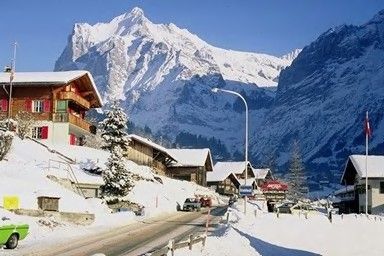

Label: 0 humanos   /  Prediction:  1 praia 1.0
/content/drive/My Drive/Base/humanos/93.jpg


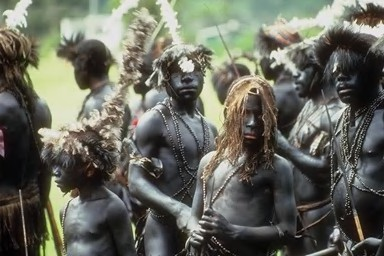

Label: 6 flores   /  Prediction:  9 comida 1.0
/content/drive/My Drive/Base/flores/696.jpg


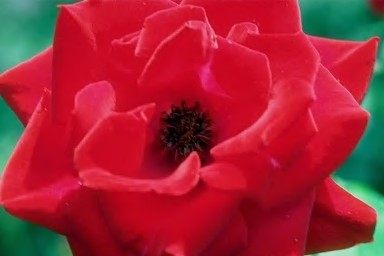

Label: 8 montanhas   /  Prediction:  1 praia 1.0
/content/drive/My Drive/Base/montanhas/825.jpg


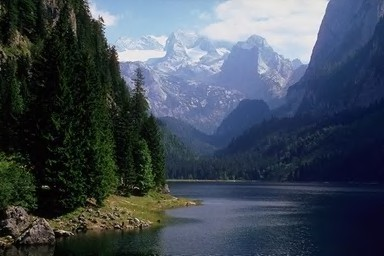

Label: 2 obras   /  Prediction:  0 humanos 1.0
/content/drive/My Drive/Base/obras/291.jpg


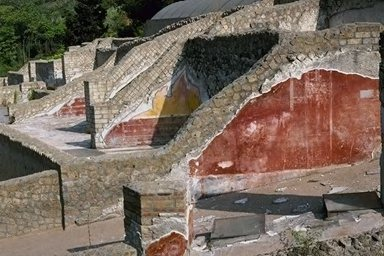

Label: 1 praia   /  Prediction:  0 humanos 1.0
/content/drive/My Drive/Base/praia/101.jpg


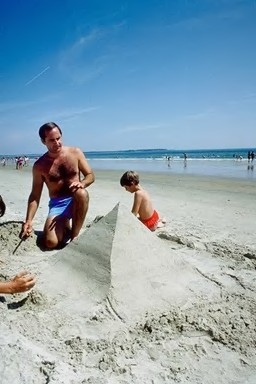

Label: 5 elefante   /  Prediction:  0 humanos 1.0
/content/drive/My Drive/Base/elefante/534.jpg


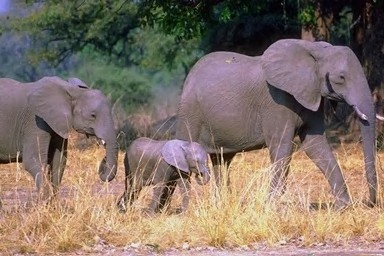

Label: 3 onibus   /  Prediction:  0 humanos 1.0
/content/drive/My Drive/Base/onibus/376.jpg


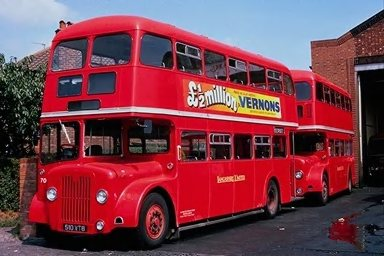

Label: 6 flores   /  Prediction:  0 humanos 1.0
/content/drive/My Drive/Base/flores/619.jpg


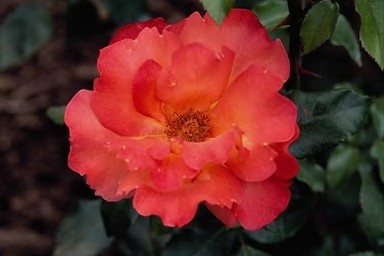

Label: 5 elefante   /  Prediction:  0 humanos 1.0
/content/drive/My Drive/Base/elefante/575.jpg


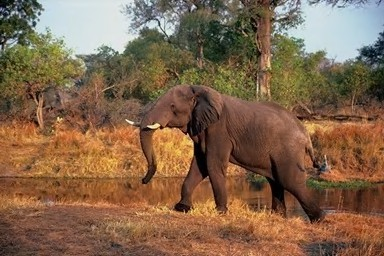

Label: 5 elefante   /  Prediction:  0 humanos 1.0
/content/drive/My Drive/Base/elefante/568.jpg


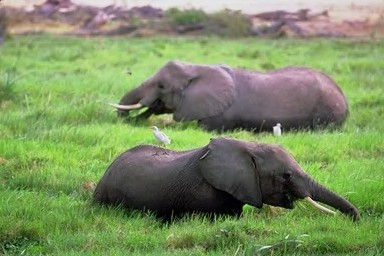

Label: 8 montanhas   /  Prediction:  0 humanos 1.0
/content/drive/My Drive/Base/montanhas/819.jpg


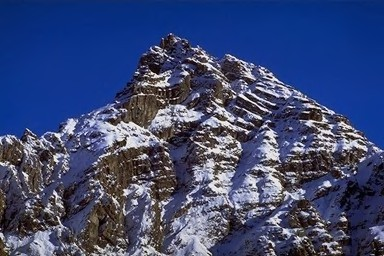

Label: 1 praia   /  Prediction:  0 humanos 1.0
/content/drive/My Drive/Base/praia/162.jpg


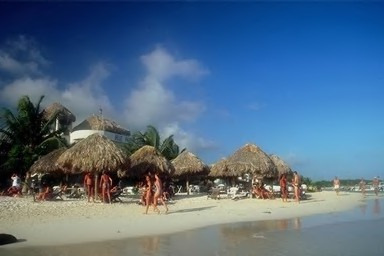

Label: 1 praia   /  Prediction:  2 obras 1.0
/content/drive/My Drive/Base/praia/123.jpg


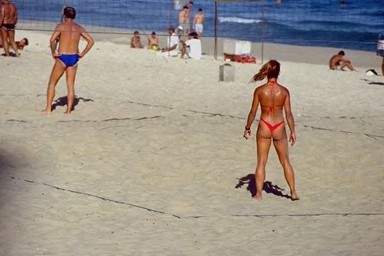

Label: 8 montanhas   /  Prediction:  0 humanos 1.0
/content/drive/My Drive/Base/montanhas/867.jpg


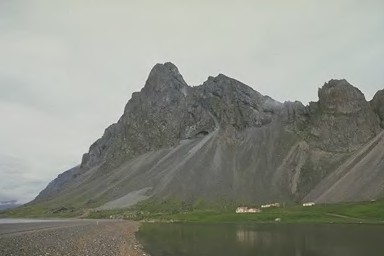

Label: 8 montanhas   /  Prediction:  0 humanos 1.0
/content/drive/My Drive/Base/montanhas/816.jpg


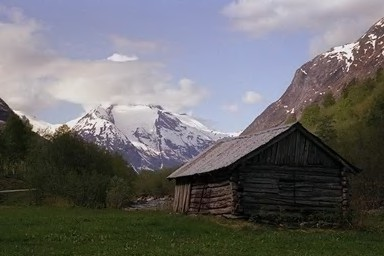

Label: 2 obras   /  Prediction:  0 humanos 1.0
/content/drive/My Drive/Base/obras/299.jpg


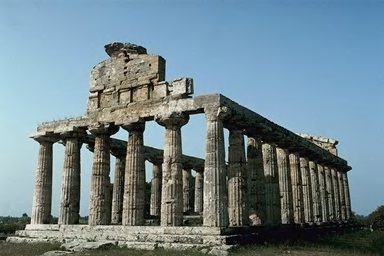

Label: 8 montanhas   /  Prediction:  1 praia 1.0
/content/drive/My Drive/Base/montanhas/801.jpg


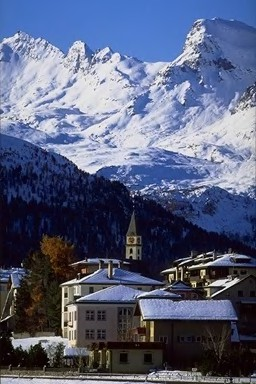

Label: 8 montanhas   /  Prediction:  1 praia 1.0
/content/drive/My Drive/Base/montanhas/891.jpg


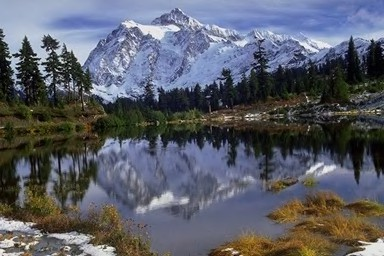

Label: 5 elefante   /  Prediction:  0 humanos 1.0
/content/drive/My Drive/Base/elefante/595.jpg


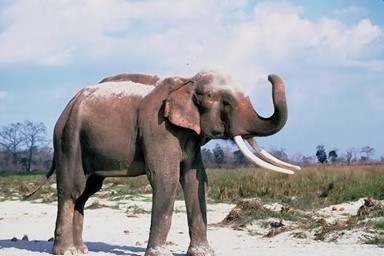

Label: 8 montanhas   /  Prediction:  0 humanos 1.0
/content/drive/My Drive/Base/montanhas/855.jpg


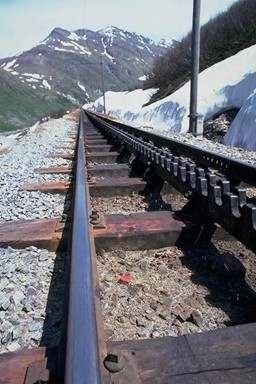

Label: 1 praia   /  Prediction:  0 humanos 1.0
/content/drive/My Drive/Base/praia/109.jpg


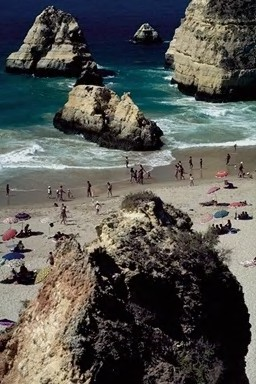

Label: 6 flores   /  Prediction:  9 comida 1.0
/content/drive/My Drive/Base/flores/656.jpg


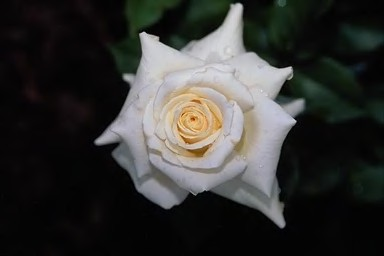

In [30]:
#@title Default title text
#treino de um classificador Naive Bayes
#usando holdout e outro usando validacao cruzada com 10 pastas. 

# Importa bibliotecas necessarias 
import numpy as np
import urllib
from sklearn.naive_bayes import GaussianNB
from sklearn import  model_selection
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd

# Labels
y = pd.read_csv('/content/drive/My Drive/y.csv', header=None)
y=y.to_numpy()
y=np.ravel(y)

print("========================Naive Bayes=============================")
# features
X = pd.read_csv('/content/drive/My Drive/X.csv', header=None)
X = X.to_numpy()

# HOLDOUT
# Holdout -> dividindo a base em treinament-o (70%) e teste (30%), estratificada
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3, random_state=42, stratify=y)

# Treina o classificador
clfa = GaussianNB()
#clfa = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
clfa = clfa.fit(X_train, y_train)

# testa usando a base de testes
predicted=clfa.predict(X_test)
predp=clfa.predict_proba(X_test)

# calcula a acurÃ¡cia na base de teste
score=clfa.score(X_test, y_test)

# calcula a matriz de confusÃ£o
matrix = confusion_matrix(y_test, predicted)

# apresenta os resultados
print("Result for X")
print("Accuracy = %.2f " % score)
print("Confusion Matrix:")
print(matrix)

# EXEMPLO USANDO VALIDAÃ‡ÃƒO CRUZADA

#clfb = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
clfb = GaussianNB()
folds=10
result = model_selection.cross_val_score(clfb, X, y, cv=folds)
print("\nCross Validation Results %d folds:" % folds)
print("Mean Accuracy: %.2f" % result.mean())
print("Mean Std: %.2f" % result.std())

# matriz de confusÃ£o da validaÃ§Ã£o cruzada
Z = model_selection.cross_val_predict(clfb, X, y, cv=folds)
cm=confusion_matrix(y, Z)
print("Confusion Matrix:")
print(cm)

print("===================================================================")
# deep features
X = pd.read_csv('/content/drive/My Drive/X_deep.csv', header=None)
X = X.to_numpy()

# HOLDOUT
# Holdout -> dividindo a base em treinament-o (70%) e teste (30%), estratificada
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3, random_state=42, stratify=y)

# Treina o classificador
clfa = GaussianNB()
#clfa = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
clfa = clfa.fit(X_train, y_train)

# testa usando a base de testes
predicted=clfa.predict(X_test)
predp=clfa.predict_proba(X_test)

# calcula a acurÃ¡cia na base de teste
score=clfa.score(X_test, y_test)

# calcula a matriz de confusÃ£o
matrix = confusion_matrix(y_test, predicted)

# apresenta os resultados
print("Result for X_deep")
print("Accuracy = %.2f " % score)
print("Confusion Matrix:")
print(matrix)

# EXEMPLO USANDO VALIDAÃ‡ÃƒO CRUZADA

#clfb = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
clfb = GaussianNB()
folds=10
result = model_selection.cross_val_score(clfb, X, y, cv=folds)
print("\nCross Validation Results %d folds:" % folds)
print("Mean Accuracy: %.2f" % result.mean())
print("Mean Std: %.2f" % result.std())

# matriz de confusÃ£o da validaÃ§Ã£o cruzada
Z = model_selection.cross_val_predict(clfb, X, y, cv=folds)
cm=confusion_matrix(y, Z)
print("Confusion Matrix:")
print(cm)

#========================================================================
# Plot mistakes (images)
import cv2
from google.colab.patches import cv2_imshow
class_names=['humanos', 'praia', 'obras', 'onibus', 'dino', 'elefante', 'flores', 'cavalos', 'montanhas', 'comida'] 
print(predicted.shape)
for i in range(len(predicted)):
    if (predicted[i] != y_test[i]):
        dist=1
        j=0
        while (j<len(X) and dist !=0): 
            dist = np.linalg.norm(X[j]-X_test[i])
            j+=1
        print("Label:", y[j-1], class_names[y[j-1]], "  /  Prediction: ", predicted[i], class_names[predicted[i]], predp[i][predicted[i]])
        name= "/content/drive/My Drive/Base/" + str(class_names[y[j-1]]) + "/" + str(j-1)+ ".jpg" 
        print(name)
        im=cv2.imread(name)
        cv2_imshow(im)
        print("=============================================================================")
#========================================================================


In [0]:
#Arvore de Decisao
print("\n========================Arvore de Decisao=============================")
import numpy as np
import urllib
from sklearn import  model_selection
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn import tree

# Labels
y = pd.read_csv('/content/drive/My Drive/y.csv', header=None)
y=y.to_numpy()
y=np.ravel(y)

# features
X = pd.read_csv('/content/drive/My Drive/X.csv', header=None)
X = X.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3, random_state=42, stratify=y)

# declara o classificador
clfa = tree.DecisionTreeClassifier(criterion='gini', max_depth=10)

# treina o classificador
clfa = clfa.fit(X_train, y_train)

# testa usando a base de testes
predicted=clfa.predict(X_test)
predicted_proba=clfa.predict_proba(X_test)

# calcula a acuracia na base de teste (taxa de acerto)
score=clfa.score(X_test, y_test)

# calcula a matriz de confusao
matrix = confusion_matrix(y_test, predicted)

# apresenta os resultados
print("Result for X")
print("\nResultados baseados em Holdout 70/30")
print("Taxa de acerto = %.2f " % score)

print("Matriz de confusao:")
print(matrix)

# EXEMPLO USANDO VALIDACAO CRUZADA
clfb = tree.DecisionTreeClassifier(criterion='gini')
folds=10
result = model_selection.cross_val_score(clfb, X, y, cv=folds)

print("\nResultados baseados em Validacao Cruzada")
print("Qtde folds: %d:" % folds)
print("Taxa de Acerto: %.2f" % result.mean())
print("Desvio padrao: %.2f" % result.std())

# matriz de confusão da validacao cruzada
predicted = model_selection.cross_val_predict(clfb, X, y, cv=folds)
cm=confusion_matrix(y, predicted)
print("Matriz de confusao:")
print(cm)

print("===================================================================")

# deep features
X = pd.read_csv('/content/drive/My Drive/X_deep.csv', header=None)
X = X.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3, random_state=42, stratify=y)

# declara o classificador
clfa = tree.DecisionTreeClassifier(criterion='gini', max_depth=15)

# treina o classificador
clfa = clfa.fit(X_train, y_train)

# testa usando a base de testes
predicted=clfa.predict(X_test)
predicted_proba=clfa.predict_proba(X_test)

# calcula a acuracia na base de teste (taxa de acerto)
score=clfa.score(X_test, y_test)

# calcula a matriz de confusao
matrix = confusion_matrix(y_test, predicted)

# apresenta os resultados
print("Result for X_deep")
print("\nResultados baseados em Holdout 70/30")
print("Taxa de acerto = %.2f " % score)

print("Matriz de confusao:")
print(matrix)

# EXEMPLO USANDO VALIDACAO CRUZADA
clfb = tree.DecisionTreeClassifier(criterion='gini')
folds=10
result = model_selection.cross_val_score(clfb, X, y, cv=folds)

print("\nResultados baseados em Validacao Cruzada")
print("Qtde folds: %d:" % folds)
print("Taxa de Acerto: %.2f" % result.mean())
print("Desvio padrao: %.2f" % result.std())

# matriz de confusão da validacao cruzada
predicted = model_selection.cross_val_predict(clfb, X, y, cv=folds)
cm=confusion_matrix(y, predicted)
print("Matriz de confusao:")
print(cm)

#========================================================================
# Plot mistakes (images)
import cv2
from google.colab.patches import cv2_imshow
class_names=['humanos', 'praia', 'obras', 'onibus', 'dino', 'elefante', 'flores', 'cavalos', 'montanhas', 'comida'] 
print(predicted.shape)
for i in range(len(predicted)):
    if (predicted[i] != y_test[i]):
        dist=1
        j=0
        while (j<len(X) and dist !=0): 
            dist = np.linalg.norm(X[j]-X_test[i])
            j+=1
        print("Label:", y[j-1], class_names[y[j-1]], "  /  Prediction: ", predicted[i], class_names[predicted[i]], predp[i][predicted[i]])
        name= "/content/drive/My Drive/Base/" + str(class_names[y[j-1]]) + "/" + str(j-1)+ ".jpg" 
        print(name)
        im=cv2.imread(name)
        cv2_imshow(im)
        print("=============================================================================")
#========================================================================


========================K-vizinhos=============================
Result for X
Accuracy = 0.44667 
Confusion Matrix:
[[ 3  0  1  0  0  2  0 23  1  0]
 [ 2 11  1  1  0  2  0 10  3  0]
 [ 3  3 11  0  0  5  0  6  2  0]
 [ 0  3  4 22  0  0  0  0  1  0]
 [ 0  0  0  0 29  0  1  0  0  0]
 [ 2  1  1  0  0 10  0 16  0  0]
 [ 1  1  2  0  0  2 12  8  2  2]
 [ 0  0  3  0  0  1  0 26  0  0]
 [ 1  2  2  0  0  5  0 14  6  0]
 [ 1  1  4  0  0  1  0 19  0  4]]

Cross Validation Results 10 folds:
Mean Accuracy: 0.47
Mean Std: 0.04
Confusion Matrix:
[[ 8  3  6  1  0  9  1 69  3  0]
 [ 7 37  7  1  1  8  0 27 12  0]
 [10 11 27  1  0 10  0 37  4  0]
 [ 1  7  9 77  0  0  0  6  0  0]
 [ 0  1  0  0 97  0  1  0  1  0]
 [ 6  1  1  0  0 50  0 41  1  0]
 [ 4  1  2  0  0  9 53 24  5  2]
 [ 2  0  3  0  0  0  0 95  0  0]
 [ 4 14  5  0  0  9  2 44 17  5]
 [ 3  3  5  0  0  7  0 65  3 14]]
Result for X_deep
Accuracy = 0.96000 
Confusion Matrix:
[[29  1  0  0  0  0  0  0  0  0]
 [ 0 26  1  1  0  0  0  0  2  0]
 [ 1  1 27 

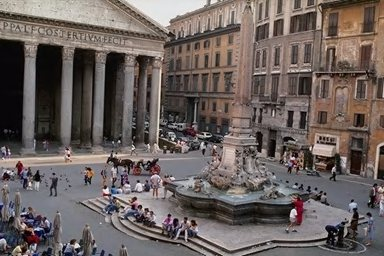

Label: 1 praia   /  Prediction:  2 obras 8.783853737690549e-240
/content/drive/My Drive/Base/praia/114.jpg


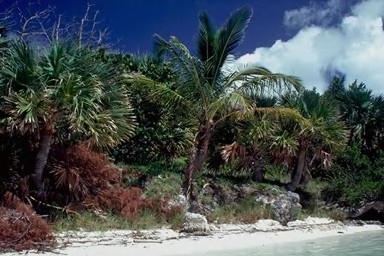

Label: 0 humanos   /  Prediction:  1 praia 1.0
/content/drive/My Drive/Base/humanos/93.jpg


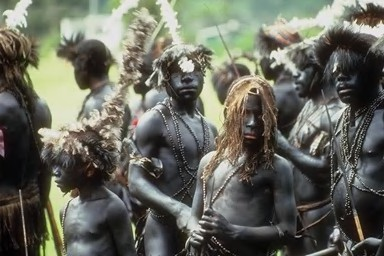

Label: 2 obras   /  Prediction:  1 praia 8.472277694059306e-260
/content/drive/My Drive/Base/obras/291.jpg


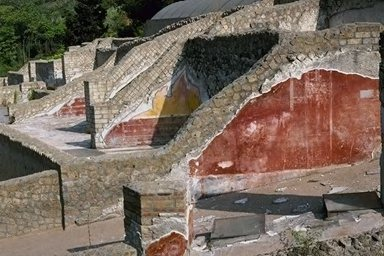

Label: 9 comida   /  Prediction:  6 flores 0.0
/content/drive/My Drive/Base/comida/931.jpg


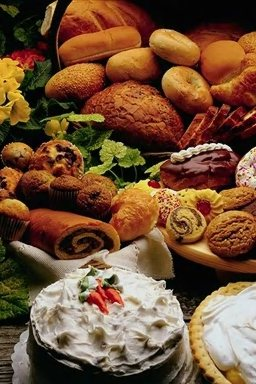

Label: 1 praia   /  Prediction:  8 montanhas 0.0
/content/drive/My Drive/Base/praia/137.jpg


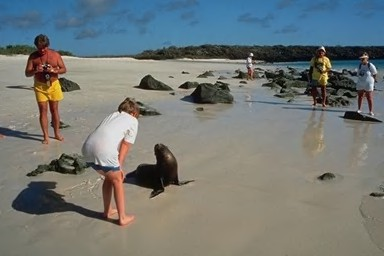

Label: 1 praia   /  Prediction:  3 onibus 0.0
/content/drive/My Drive/Base/praia/101.jpg


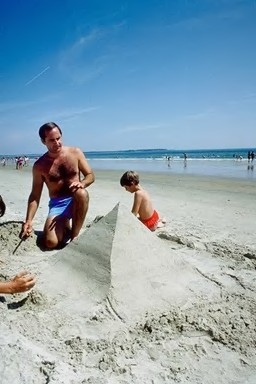

Label: 1 praia   /  Prediction:  8 montanhas 4.244065011986222e-116
/content/drive/My Drive/Base/praia/133.jpg


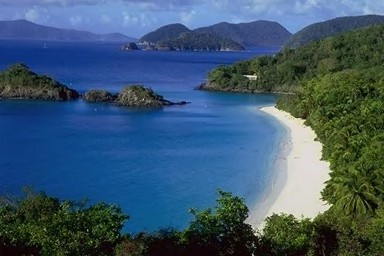

Label: 9 comida   /  Prediction:  6 flores 0.0
/content/drive/My Drive/Base/comida/952.jpg


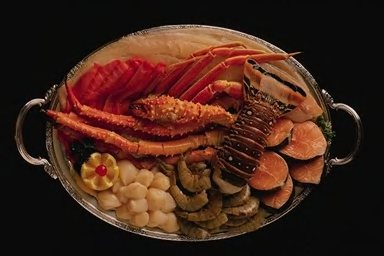

Label: 2 obras   /  Prediction:  4 dino 0.0
/content/drive/My Drive/Base/obras/299.jpg


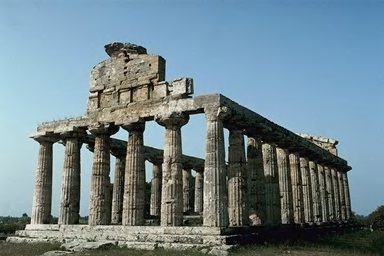

Label: 9 comida   /  Prediction:  6 flores 0.0
/content/drive/My Drive/Base/comida/955.jpg


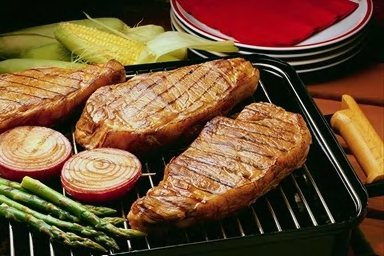

Label: 9 comida   /  Prediction:  8 montanhas 0.0
/content/drive/My Drive/Base/comida/903.jpg


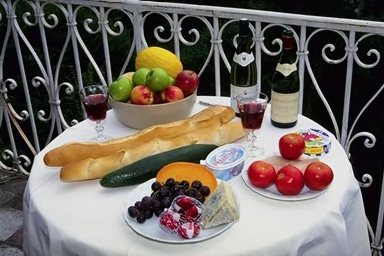

In [31]:
#K-vizinhos
print("\n========================K-vizinhos=============================")
import numpy as np
import urllib
from sklearn import  model_selection
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier

# Labels
y = pd.read_csv('/content/drive/My Drive/y.csv', header=None)
y=y.to_numpy()
y=np.ravel(y)

# features
X = pd.read_csv('/content/drive/My Drive/X.csv', header=None)
X = X.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3, random_state=42, stratify=y)

# declara o classificador
clfa = KNeighborsClassifier(n_neighbors=1)

# treina o classificador
clfa = clfa.fit(X_train, y_train)

# testa usando a base de testes
predicted=clfa.predict(X_test)

# calcula a acurácia na base de teste
score=clfa.score(X_test, y_test)

# calcula a matriz de confusão
matrix = confusion_matrix(y_test, predicted)

# apresenta os resultados
print("Result for X")
print("Accuracy = %.5f " % score)
print("Confusion Matrix:")
print(matrix)

# EXEMPLO USANDO VALIDAÇÃO CRUZADA
clfb = KNeighborsClassifier(n_neighbors=1)
folds=10
result = model_selection.cross_val_score(clfb, X, y, cv=folds)
print("\nCross Validation Results %d folds:" % folds)
print("Mean Accuracy: %.2f" % result.mean())
print("Mean Std: %.2f" % result.std())

# matriz de confusão da validação cruzada
Z = model_selection.cross_val_predict(clfb, X, y, cv=folds)
cm=confusion_matrix(y, Z)
print("Confusion Matrix:")
print(cm)

print("==================================================================")
# deep features
X = pd.read_csv('/content/drive/My Drive/X_deep.csv', header=None)
X = X.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3, random_state=42, stratify=y)

# declara o classificador
clfa = KNeighborsClassifier(n_neighbors=3)

# treina o classificador
clfa = clfa.fit(X_train, y_train)

# testa usando a base de testes
predicted=clfa.predict(X_test)

# calcula a acurácia na base de teste
score=clfa.score(X_test, y_test)

# calcula a matriz de confusão
matrix = confusion_matrix(y_test, predicted)

# apresenta os resultados
print("Result for X_deep")
print("Accuracy = %.5f " % score)
print("Confusion Matrix:")
print(matrix)

# EXEMPLO USANDO VALIDAÇÃO CRUZADA
clfb = KNeighborsClassifier(n_neighbors=1)
folds=10
result = model_selection.cross_val_score(clfb, X, y, cv=folds)
print("\nCross Validation Results %d folds:" % folds)
print("Mean Accuracy: %.2f" % result.mean())
print("Mean Std: %.2f" % result.std())

# matriz de confusão da validação cruzada
Z = model_selection.cross_val_predict(clfb, X, y, cv=folds)
cm=confusion_matrix(y, Z)
print("Confusion Matrix:")
print(cm)

#========================================================================
# Plot mistakes (images)
import cv2
from google.colab.patches import cv2_imshow
class_names=['humanos', 'praia', 'obras', 'onibus', 'dino', 'elefante', 'flores', 'cavalos', 'montanhas', 'comida'] 
print(predicted.shape)
for i in range(len(predicted)):
    if (predicted[i] != y_test[i]):
        dist=1
        j=0
        while (j<len(X) and dist !=0): 
            dist = np.linalg.norm(X[j]-X_test[i])
            j+=1
        print("Label:", y[j-1], class_names[y[j-1]], "  /  Prediction: ", predicted[i], class_names[predicted[i]], predp[i][predicted[i]])
        name= "/content/drive/My Drive/Base/" + str(class_names[y[j-1]]) + "/" + str(j-1)+ ".jpg" 
        print(name)
        im=cv2.imread(name)
        cv2_imshow(im)
        print("=============================================================================")
#========================================================================

In [0]:
#Maquina de vetor de suporte
print("\n========================Maquina de vetor de suporte=============================")
import numpy as np
import urllib
from sklearn import  model_selection
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#ignorando erros
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Labels
y = pd.read_csv('/content/drive/My Drive/y.csv', header=None)
y=y.to_numpy()
y=np.ravel(y)

# features
X = pd.read_csv('/content/drive/My Drive/X.csv', header=None)
X = X.to_numpy()

# EXEMPLO USANDO HOLDOUT
# Holdout -> dividindo a base em treinamento (70%) e teste (30%), estratificada
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3, random_state=42, stratify=y)

# Treina o classificador

#Definição dos parâmetros a serem avaliados no ajuste fino do SVM
parameters = [
  {'C': [0.1, 0.5, 1, 10, 100, 500, 1000], 'kernel': ['linear']},
  {'C': [0.1, 0.5, 1, 10, 100, 500, 1000], 'gamma': [0.1, 0.001, 0.0001, 0.00001], 'kernel': ['rbf']},
 ]

clfa = SVC()
clfa = GridSearchCV(clfa, parameters, scoring = 'accuracy', cv=10, iid=False)
clfa = clfa.fit(X_train, y_train)
print(clfa.best_params_)

# testa usando a base de testes
predicted=clfa.predict(X_test)

# calcula a acurácia na base de teste
score=clfa.score(X_test, y_test)

# calcula a matriz de confusão
matrix = confusion_matrix(y_test, predicted)

print("Result for X")
# apresenta os resultados
print("Accuracy = %.2f " % score)
print("Confusion Matrix:")
print(matrix)

# EXEMPLO USANDO VALIDAÇÃO CRUZADA
clfb = SVC()
clfb = GridSearchCV(clfb, parameters, scoring = 'accuracy', cv=10, iid=False)
folds=10
result = model_selection.cross_val_score(clfb, X, y, cv=folds)
print("\nCross Validation Results %d folds:" % folds)
print("Mean Accuracy: %.2f" % result.mean())
print("Mean Std: %.2f" % result.std())

# matriz de confusão da validação cruzada
Z = model_selection.cross_val_predict(clfb, X, y, cv=folds)
cm=confusion_matrix(y, Z)
print("Confusion Matrix:")
print(cm)

print("=================================================================")

# deep features
X = pd.read_csv('/content/drive/My Drive/X_deep.csv', header=None)
X = X.to_numpy()

# EXEMPLO USANDO HOLDOUT
# Holdout -> dividindo a base em treinamento (70%) e teste (30%), estratificada
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3, random_state=42, stratify=y)

# Treina o classificador

#Definição dos parâmetros a serem avaliados no ajuste fino do SVM
parameters = [
  {'C': [0.1, 0.5, 1, 10, 100, 500, 1000], 'kernel': ['linear']},
  {'C': [0.1, 0.5, 1, 10, 100, 500, 1000], 'gamma': [0.1, 0.001, 0.0001, 0.00001], 'kernel': ['rbf']},
 ]

clfa = SVC()
clfa = GridSearchCV(clfa, parameters, scoring = 'accuracy', cv=10, iid=False)
clfa = clfa.fit(X_train, y_train)
print(clfa.best_params_)

# testa usando a base de testes
predicted=clfa.predict(X_test)

# calcula a acurácia na base de teste
score=clfa.score(X_test, y_test)

# calcula a matriz de confusão
matrix = confusion_matrix(y_test, predicted)

print("Result for X_deep")
# apresenta os resultados
print("Accuracy = %.2f " % score)
print("Confusion Matrix:")
print(matrix)

# EXEMPLO USANDO VALIDAÇÃO CRUZADA
clfb = SVC()
clfb = GridSearchCV(clfb, parameters, scoring = 'accuracy', cv=10, iid=False)
folds=10
result = model_selection.cross_val_score(clfb, X, y, cv=folds)
print("\nCross Validation Results %d folds:" % folds)
print("Mean Accuracy: %.2f" % result.mean())
print("Mean Std: %.2f" % result.std())

# matriz de confusão da validação cruzada
Z = model_selection.cross_val_predict(clfb, X, y, cv=folds)
cm=confusion_matrix(y, Z)
print("Confusion Matrix:")
print(cm)

#========================================================================
# Plot mistakes (images)
import cv2
from google.colab.patches import cv2_imshow
class_names=['humanos', 'praia', 'obras', 'onibus', 'dino', 'elefante', 'flores', 'cavalos', 'montanhas', 'comida'] 
print(predicted.shape)
for i in range(len(predicted)):
    if (predicted[i] != y_test[i]):
        dist=1
        j=0
        while (j<len(X) and dist !=0): 
            dist = np.linalg.norm(X[j]-X_test[i])
            j+=1
        print("Label:", y[j-1], class_names[y[j-1]], "  /  Prediction: ", predicted[i], class_names[predicted[i]], predp[i][predicted[i]])
        name= "/content/drive/My Drive/Base/" + str(class_names[y[j-1]]) + "/" + str(j-1)+ ".jpg" 
        print(name)
        im=cv2.imread(name)
        cv2_imshow(im)
        print("=============================================================================")
#========================================================================

In [0]:
# Plot mistakes (images)
print(predicted.shape)
for i in range(len(predicted)):
    if (predicted[i] != y_test[i]):
        dist=1
        j=0
        while (j<len(X) and dist !=0): 
            dist = np.linalg.norm(X[j]-X_test[i])
            j+=1
        print("Label:", y[j-1], class_names[y[j-1]], "  /  Prediction: ", predicted[i], class_names[predicted[i]], predp[i][predicted[i]])
        name= "/content/drive/My Drive/Base/" + str(class_names[y[j-1]]) + "/" + str(j-1)+ ".jpg" 
        print(name)
        im=cv2.imread(name)
        cv2_imshow(im)
        print("=============================================================================")
  
